# Running mapQC, detailed

In this tutorial, we take a closer look at how to run mapQC, how to set its parameters, and some options for trouble-shooting. For a shorter and simpler introduction to mapQC, start with the mapqc [quickstart tutorial notebook](./mapqc_quickstart.ipynb)

In [1]:
import scanpy as sc
import mapqc
import matplotlib.pyplot as plt

Let's load the data already downloaded in the mapqc_quickstart tutorial (see the quickstart tutorial notebook for a description of the data and the references).

In [2]:
adata = sc.read("./mapped_q_and_r.h5ad")

## Run mapQC

Let's run mapQC. Let me explain in some more detail how to set some of the parameters for `mapqc.run_mapqc()`, and what they are for.

**Neighborhood-related parameters**:
MapQC calculates the distance of query samples to the reference (i.e. its average distance to other reference samples) in specific neighborhoods. Within these neighborhoods, mapQC considers the range of inter-sample distances between reference samples themselves as "normal". Anything outside of that normal will get a high mapQC score. 
- `min_k`: Given the neighborhood-specific determination of normal inter-sample distances, we want these distances to represent natural variation between individuals within a specific cell type or state. Therefore, we should set our min_k to approximately the minimum size we expect a cell state to have in our reference, and not too much higher than that.<br>
   - Example 1: if the reference includes only a single cell-type (e.g. an NK cell atlas), and consists of let's say 20,000 cells from control samples, we can set our k rather high. Maybe these NK cells have three or four subtypes of interest, each of n=7000 cells, in that case you could set your min_k to e.g. 4000, such that we take into account about half of the subtype in each neighborhood.
   - Example 2: The Human Lung Cell Atlas reference includes about 60 cell type annotations. Most of the cell types in the atlas include 500 cells or more. We therefore set our k_min to 500, possibly having biased mapQC scores for cell types smaller than that. However, we do not want to set our k_min too low, as it will give as a worse estimate for inter-sample distances for the rest of the cell types.
- `max_k`: In case a specific neighborhood of size min_k does not pass the minimum filter requirements (a minimum number of reference samples min_n_samples_r, default is set to 3, with at least min_n_cells, default set to 10), mapQC will increase the neighborhood size. This is for example useful if you have a lot more query than reference cells for a specific cell type. It is also useful if your mapping was bad, and the query is not mixing with the reference for many cell types. We recommend setting this to about 5-10 times your min_k. Setting this very high will slow down mapQC calculations, and will make mapQC less sensitive to smaller subsets of cells that are distant to the reference. We therefore recommend to not make it too high (>10 times min_k).
- `n_nhoods`: mapQC scores are calculated per neighborhood, and after that merged across all the neighborhoods that a query cell was part of. The ideal is that more or less all query cells are covered by a few neighborhoods. The right setting for this parameter depends on the quality of the mapping and the cell type diversity in your query. A good mimimum starting point is n_query_cells / min_k * 3, or so. The higher your n_nhoods, the more precise and complete your mapQC scores, but the slower the calculations. 

When running `mapqc.evaluate()`, you will get to know what percentage of your query cells was sampled given your n_nhoods and min_k and max_k settings. Depending on that outcome, you can adapt your n_nhoods and max and min_k parameter settings. This will be explained in more detail below.

**Filtering-related parameters**: MapQC leaves out neighborhoods that do not pass our filtering criteria. Specifically, mapQC only takes into account samples with `min_n_cells` cell or more in a given neighborhood, and only takes into account neighborhoods that include at least `min_n_samples_r` such reference samples. If you are working with a very large reference, you can set these filtering settings more strict to get more robust results. If you notice, when running mapqc.evaluate(), that most of your neighborhoods have been filtered out due to too few reference samples in the neighborhood, you can set them more leniently again. Finally, mapQC is meant to run on mappings onto a large-scale reference that includes many different studies. However, if you run it on a smaller reference anyway, e.g. including only one or two studies, we recommend setting the `exclude_same_study` argument to `False` instead of the default `True`. In this way, inter-sample distances of samples from the same reference study, normally not considered by mapQC, will be taken into account to calculate the reference null distributions.

**Output-related parameters**: It is possible to store some extra mapQC output, besides the .obs columns it automatically adds to your input adata object. These will help you get a better understanding of mapQC's filtering and inter-sample distances, and can therefore be useful e.g. for trouble-shooting. Specifically, you can set `return_nhood_info_df` to `True` to get a pandas DataFrame with filtering information per neighborhood, and `return_sample_dists_to_ref_df` to `True` to get a DataFrame with the distance of each sample to the reference for every neighborhood.

Now let's run mapQC:

In [3]:
%%time
# we add the line above just to time how long the run_mapqc() command takes
nhood_info_df, sample_dists = mapqc.run_mapqc(
    adata=adata,
    adata_emb_loc="X",  # our mapped embedding is in adata.X
    ref_q_key="r_or_q",  # .obs column with reference/query information
    q_cat="q",  # category for query
    r_cat="r",  # category for reference
    sample_key="sample",  # .obs column with sample information
    n_nhoods=200,  # number of neighborhoods to use for calculation of mapQC scores
    k_min=500,  # minimum neighborhood size
    k_max=2500,  # maximum neighborhood size
    min_n_samples_r=3,  # default
    min_n_cells=10,  # default
    study_key="study",  # .obs column with study/dataset information
    grouping_key="leiden",  # .obs column with a grouping of the data (not required)
    seed=10,  # set the seed for reproducibility
    overwrite=True,  # this will overwrite previously calculated mapqc output in your adata object
    return_nhood_info_df=True,
    return_sample_dists_to_ref_df=True,
)

CPU times: user 28.6 s, sys: 1.14 s, total: 29.8 s
Wall time: 33.8 s


And let's get the basic evaluation statistics:

In [4]:
stats = mapqc.evaluate(
    adata,
    case_control_key="lung_condition",
    case_cats=["IPF"],  # these will be considered separately
    control_cats=["Healthy"],  # these will all be considered controls
)

20.0% of neighborhoods passed filtering (40 out of 200).
91.4% of cells were sampled (29226 out of 31990).
69.8% of sampled cells passed filtering (20394 out of 29226 sampled cells).
Percentage of Control (Healthy) cells (that passed filtering) distant to the reference (mapQC score > 2): 7.7%
Percentage of Case (IPF) cells (that passed filtering) distant to the reference (mapQC score > 2): 7.6%


## Explore results and adjust parameters

In the evaluation above, we see that only 20% of our neighborhoods passed filtering, that 91% of cells were sampled, but that only 70% of those passed filtering. That is suboptimal; we do not have results for quite a large subset of our cells. We can now look at the `nhood_info_df` DataFrame we got as part of the `run_mapQC` output, to better understand what went wrong/why so many neighborhoods were filtered out:

In [5]:
nhood_info_df

,nhood_number,filter_info,k,samples_q,knn_barcodes
CATATTCAGTGGGCTA_IPF3_tsukui,0.0,not enough reference samples,NaN,"[IPF1_Lin, IPF2_Lin, IPF3_All, IPF3_Lin, NML2_...","[CATATTCAGTGGGCTA_IPF3_tsukui, TGAAAGAGTAGCTGC..."
TTGGCAACAATGCCAT_IPF2_tsukui,1.0,not enough reference samples,NaN,"[IPF1_Lin, IPF2_All, IPF2_Lin, IPF3_All, IPF3_...","[TTGGCAACAATGCCAT_IPF2_tsukui, CATATGGGTTACCAG..."
ATCGAGTCACTGTCGG_IPF3_tsukui,2.0,not enough reference samples,NaN,"[IPF1_Lin, IPF2_Lin, IPF3_All, IPF3_Lin, NML2_...","[ATCGAGTCACTGTCGG_IPF3_tsukui, ATGAGGGAGTAAGTA..."
GACGCGTAGAGTAATC_IPF2_tsukui,3.0,not enough reference samples from different st...,NaN,"[IPF1_Lin, IPF2_All, IPF2_Lin, IPF3_All, IPF3_...","[GACGCGTAGAGTAATC_IPF2_tsukui, ACGGGTCGTGAACCT..."
TGGCGCATCGCCCTTA_NML2_tsukui,4.0,pass,1078.0,"[IPF1_Lin, IPF2_Lin, IPF3_Lin, NML2_All, NML2_...","[TGGCGCATCGCCCTTA_NML2_tsukui, CGGAGTCAGACACGA..."
...,...,...,...,...,...
CTACGTCCATTCCTCG_IPF2_tsukui,195.0,not enough reference samples,NaN,"[IPF1_Lin, IPF2_Lin, IPF3_All, IPF3_Lin]","[CTACGTCCATTCCTCG_IPF2_tsukui, GGGTTGCTCAGGATC..."
GATGAAAGTTGATTCG_IPF2_tsukui,196.0,pass,500.0,"[IPF1_Lin, IPF2_All, IPF2_Lin, IPF3_Lin, NML2_...","[GATGAAAGTTGATTCG_IPF2_tsukui, TTTATGCGTAGAGGA..."
GGGATGATCCTAGAAC_IPF2_tsukui,197.0,not enough reference samples,NaN,"[IPF1_Lin, IPF2_All, IPF2_Lin, IPF3_All, IPF3_...","[GGGATGATCCTAGAAC_IPF2_tsukui, CGATTGACACAGACA..."
TGGTTAGAGGACAGCT_NML3_tsukui,198.0,pass,2232.0,"[IPF1_Lin, IPF2_All, IPF2_Lin, IPF3_All, IPF3_...","[TGGTTAGAGGACAGCT_NML3_tsukui, CCCTCCTCAAGGTTC..."


We can also look at this with a plot:

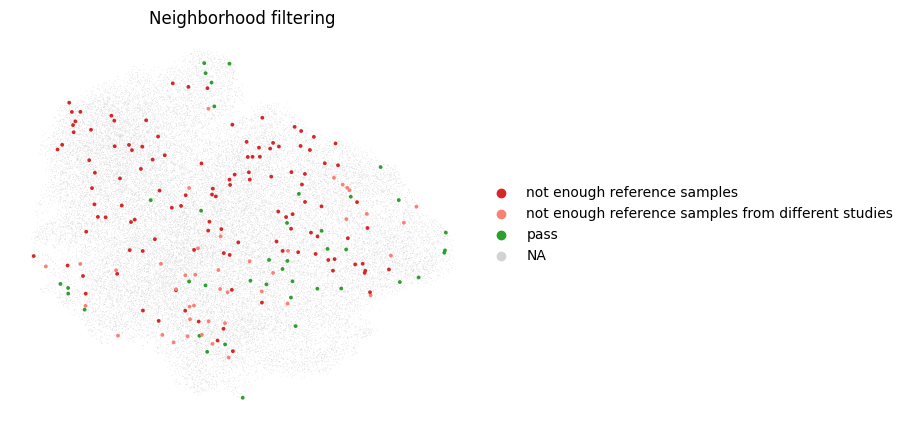

In [6]:
mapqc.pl.umap.neighborhood_filtering(adata)

It seems like we have too few reference samples in our neighborhoods. This can happen when we have many more query than reference cells, or when our query separates from the reference in the mapping. Let's take a look at the query reference distribution of our cells in the umap:

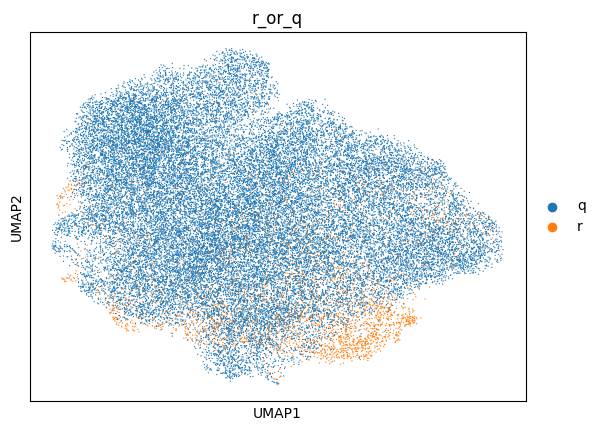

In [7]:
sc.pl.umap(adata, color="r_or_q")

Indeed, for this specific example we have many more query than reference cells, and they largely separate from the reference. We will therefore have to increase our neighborhood size, by increasing the max_k. We will leave the min_k as is, as it was based on the cell type size in our reference. Let's try that out. Note that, due to the increased neighborhood size, mapQC will take longer to run. We want to do this carefully, because the larger the neighborhood size, the less sensitive mapQC becomes. We will start with a max_k of 5000 instead of 2500.

In [8]:
%%time
nhood_info_df, sample_dists = mapqc.run_mapqc(
    adata=adata,
    adata_emb_loc="X",
    ref_q_key="r_or_q",
    q_cat="q",
    r_cat="r",
    sample_key="sample",
    n_nhoods=200,
    k_min=500,
    k_max=5000,  # increased maximum neighborhood size
    min_n_samples_r=3,
    min_n_cells=10,
    study_key="study",
    grouping_key="leiden",
    seed=10,
    overwrite=True,
    return_nhood_info_df=True,
    return_sample_dists_to_ref_df=True,
)

CPU times: user 1min 39s, sys: 725 ms, total: 1min 40s
Wall time: 1min 16s


In [ ]:
stats = mapqc.evaluate(
    adata,
    case_control_key="lung_condition",
    case_cats=["IPF"],  # these will be considered separately
    control_cats=["Healthy"],  # these will all be considered controls
)

59.0% of neighborhoods passed filtering (118 out of 200).
96.8% of cells were sampled (30981 out of 31990).
95.7% of sampled cells passed filtering (29644 out of 30981 sampled cells).
Percentage of Control (Healthy) cells (that passed filtering) distant to the reference (mapQC score > 2): 2.6%
Percentage of Case (IPF) cells (that passed filtering) distant to the reference (mapQC score > 2): 6.2%


This looks much better. We sampled 97% of cells, and despite only 59% of neighborhoods passing our filters, 96% of our sampled cells still passed filtering (this is because a cell is often part of multiple neighborhoods, and it will have results as soon as one of those passes filtering). We want about 95% or more of our cells to be sampled, and again most of those (>95%) to pass filtering.<br>We can actually take a look at the size to which our neighborhoods were increased, in the `k` column of our `nhood_info_df`. Here we see that we actually needed quite a large k for many of our neighborhoods to pass our filtering settings.

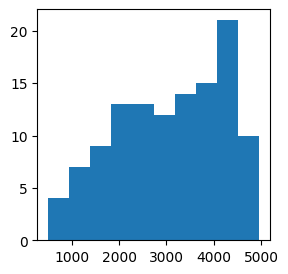

In [10]:
plt.subplots(figsize=(3, 3))
plt.hist(nhood_info_df.k)
plt.show()

Now, let's look into the results.

## Plot final results

Let's start with the most important plots: the mapQC scores.

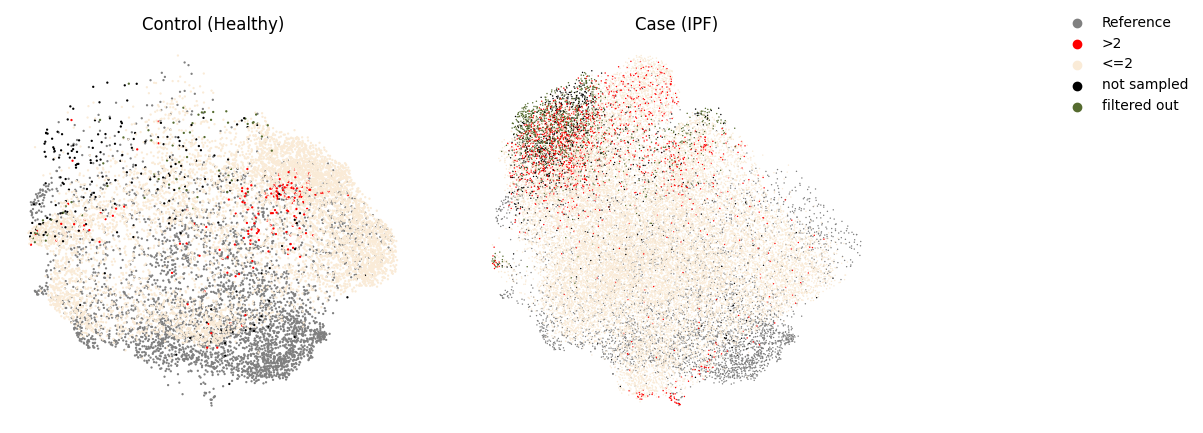

In [11]:
mapqc.pl.umap.mapqc_scores_binary(adata)

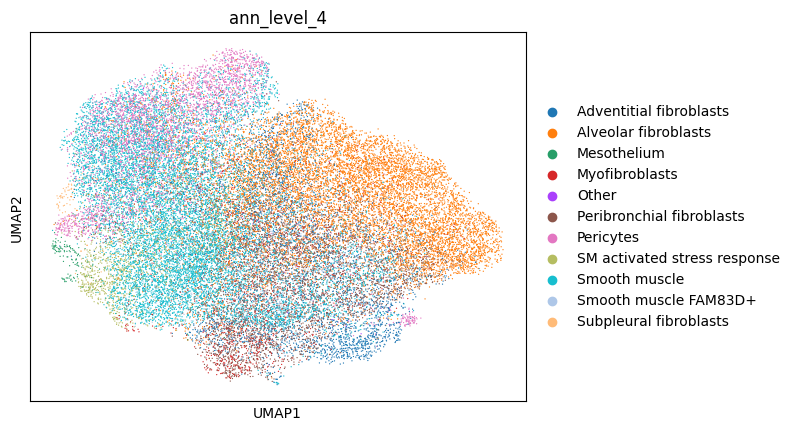

In [12]:
sc.pl.umap(adata, color="ann_level_4")

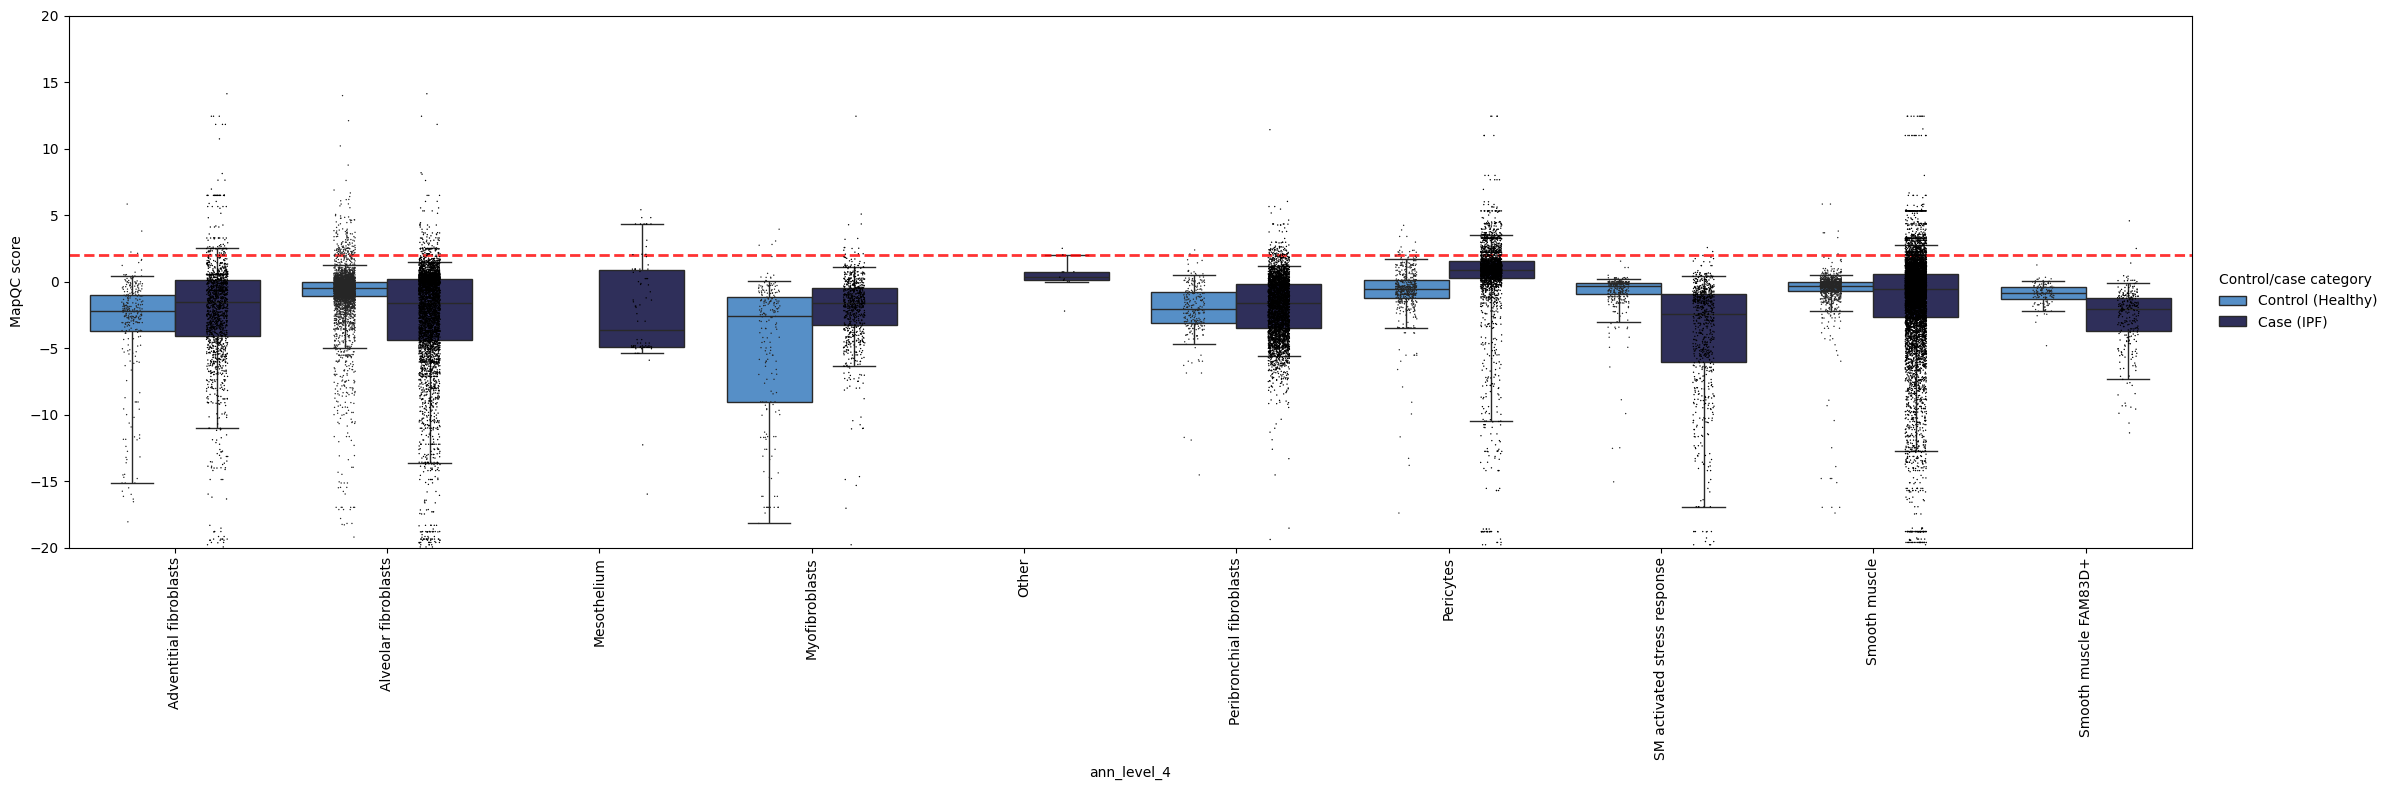

In [13]:
mapqc.pl.boxplot.mapqc_scores(adata, grouping_key="ann_level_4", ylim=(-20, 20))

Here, we see, like in the quickstart tutorial, that the mapping largely looks good: the control cells generally have a mapQC score <2. As we set our max_k quite a bit higher than in the mapqc_quickstart tutorial, we lost some sensitivity to very rare cell states that are distant from the reference, such as the "SM activated stress response" subtype. Fortunately, such an increase in max_k is  usually not necessary, as normally the query is much smaller than the reference (this query dataset performed enrichment of (normally rare) stromal cells before sequencing). Moreover, we still see that pericytes and smooth muscle cells appear to have a subset of cells with a disease-specific phenotype (mapqc score > 2)! These cell types (and in particular the cells with high mapQC scores) would be a good starting point for your data analysis.

To get an even more detailed understanding of where mapQC scores are high, we can color the dots in the above plot by a metadata category. Let's color them by donor, to see if the high mapQC scores in pericytes and smooth muscle cells observed in IPF come from only one donor, or are seen across donors. 

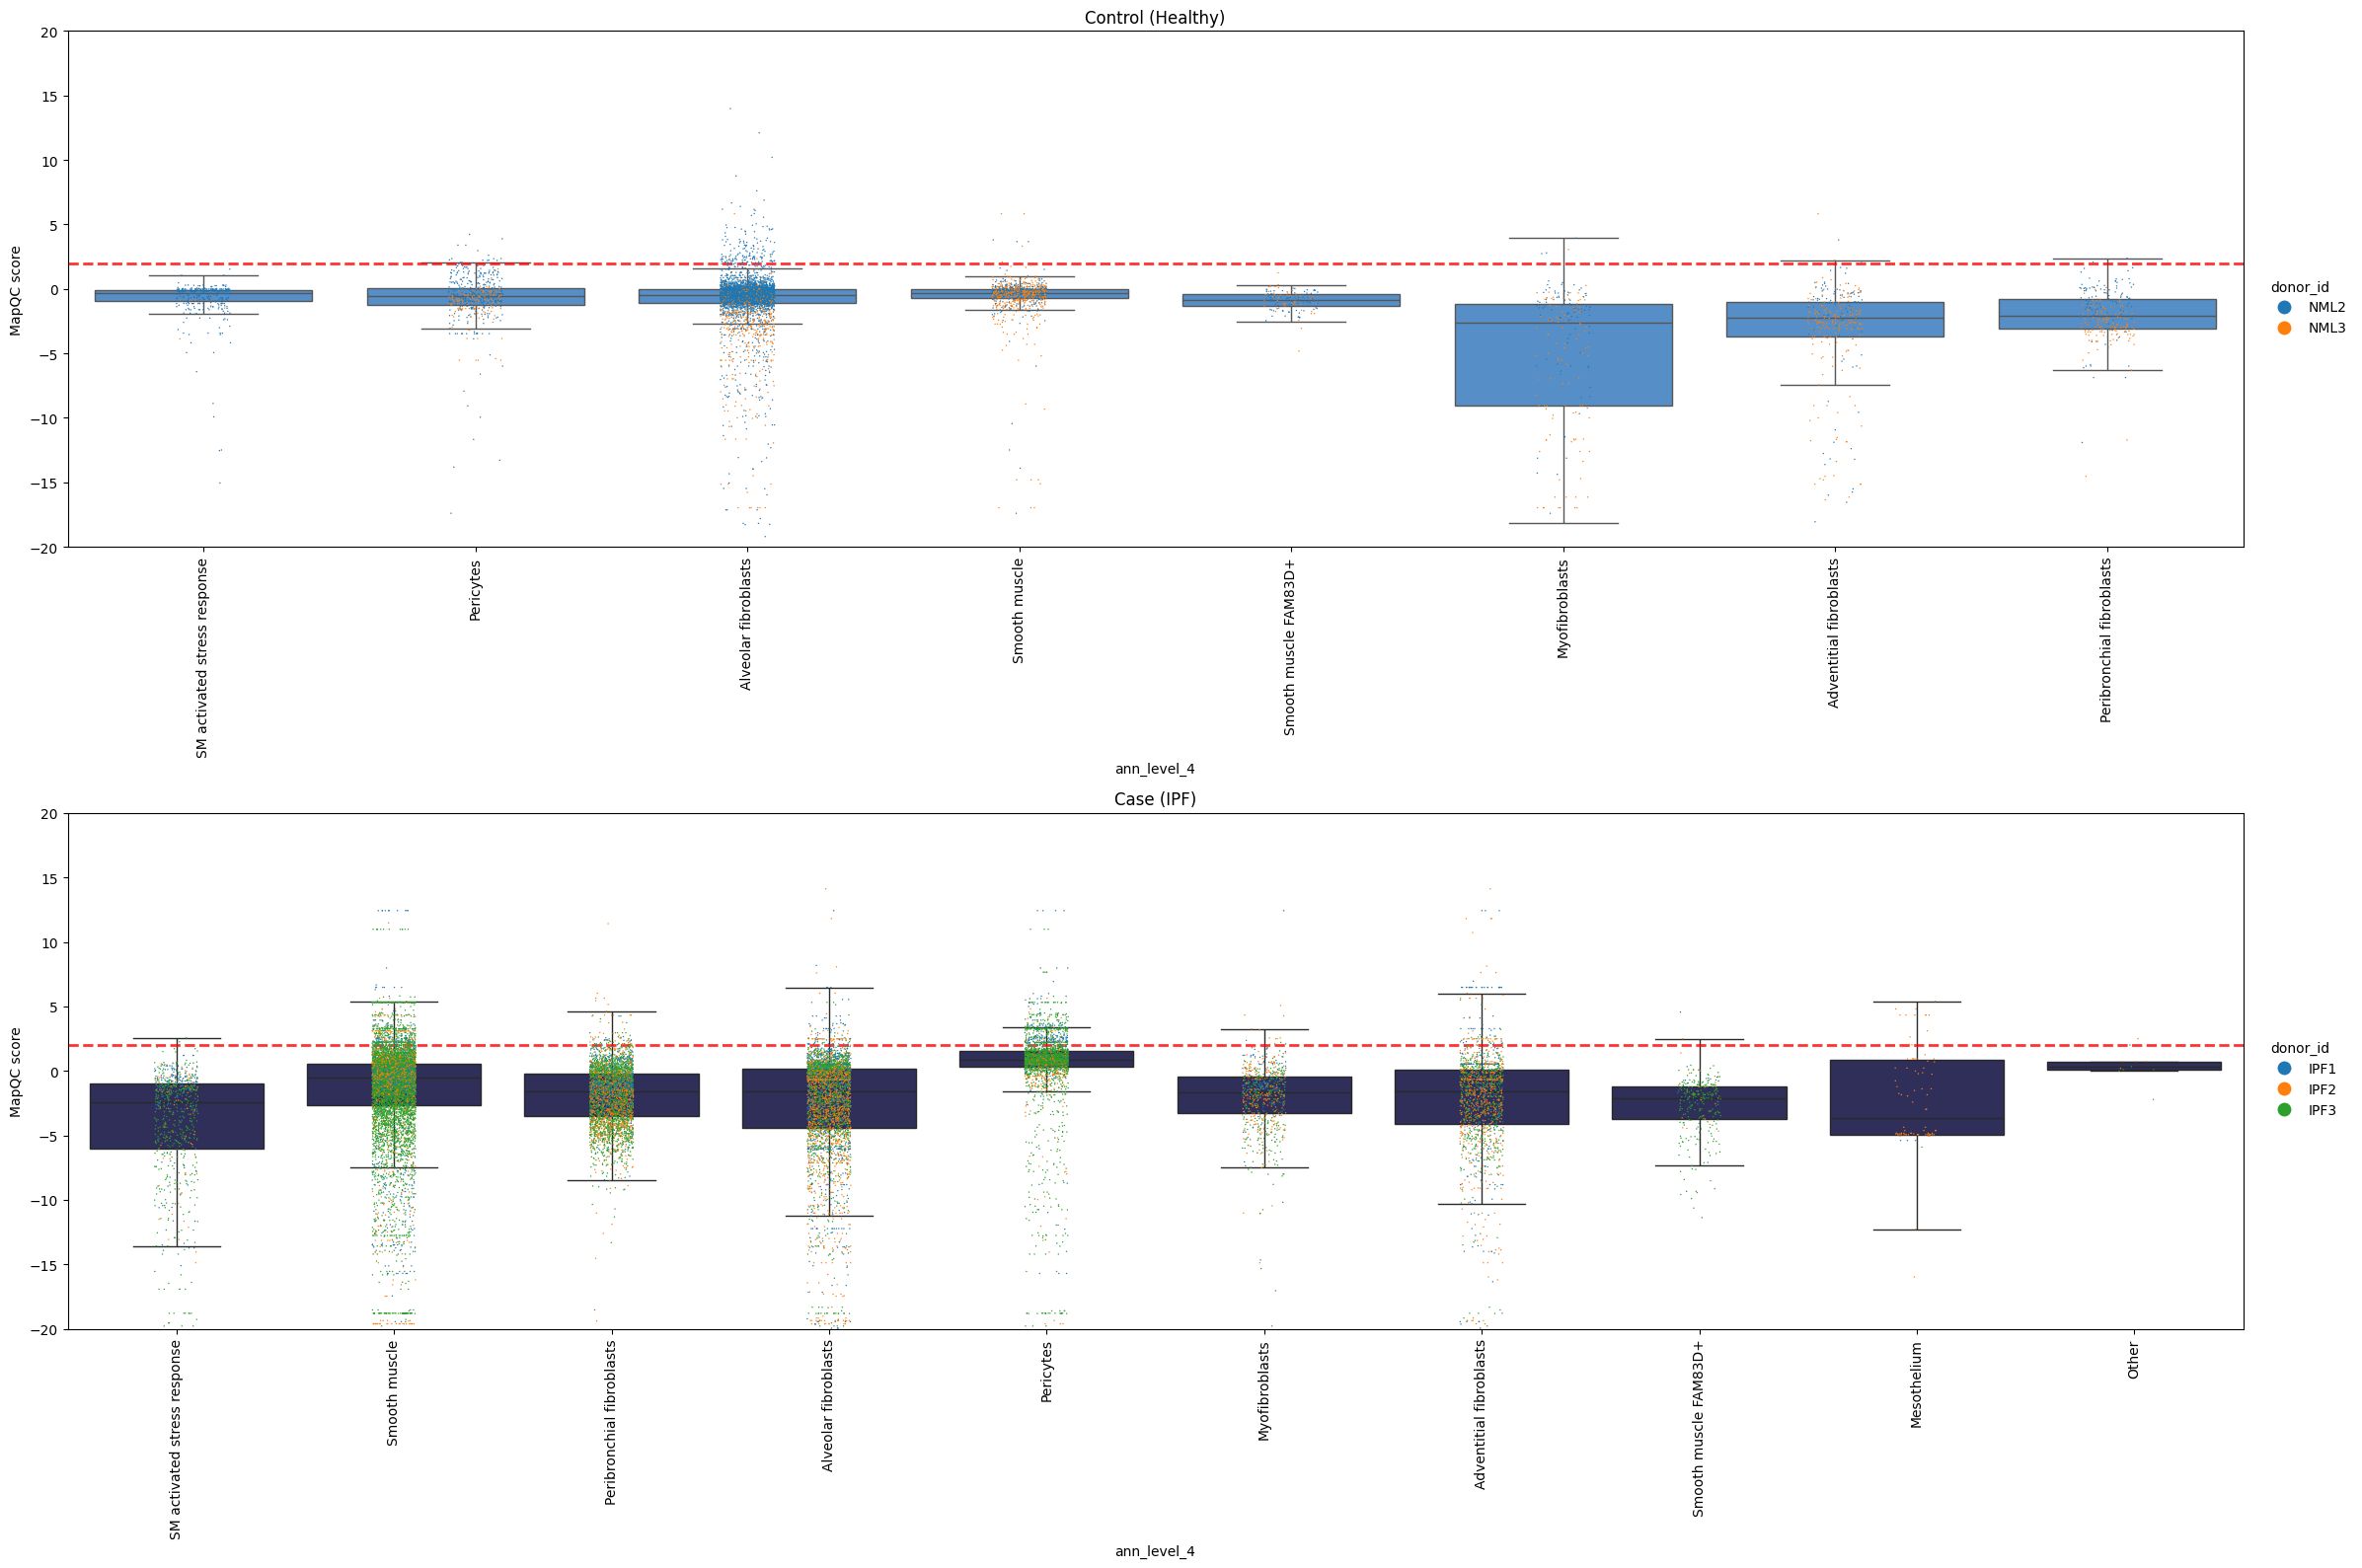

In [14]:
mapqc.pl.boxplot.mapqc_scores(adata, grouping_key="ann_level_4", ylim=(-20, 20), color_dots_by="donor_id")

It looks like multiple donors with IPF show high mapQC scores for pericytes and smooth muscle cells. This is another indication that we are not looking at a sample-specific artifact!

If you want to see what's going on in specific neighborhoods (the basis for mapQC score calculation), you can take a look at the following plot. It shows you sample distances to the reference, splitting samples by referece, query control, and query case. We can for example take a look what our neighborhoods with a smooth muscle cell as their center cell look like. Below we see that many of these neighborhoods show increased distance to the reference for case samples compared to control samples. That is reassuring: the mapQC scores are not driven by a single outlier neighborhood.

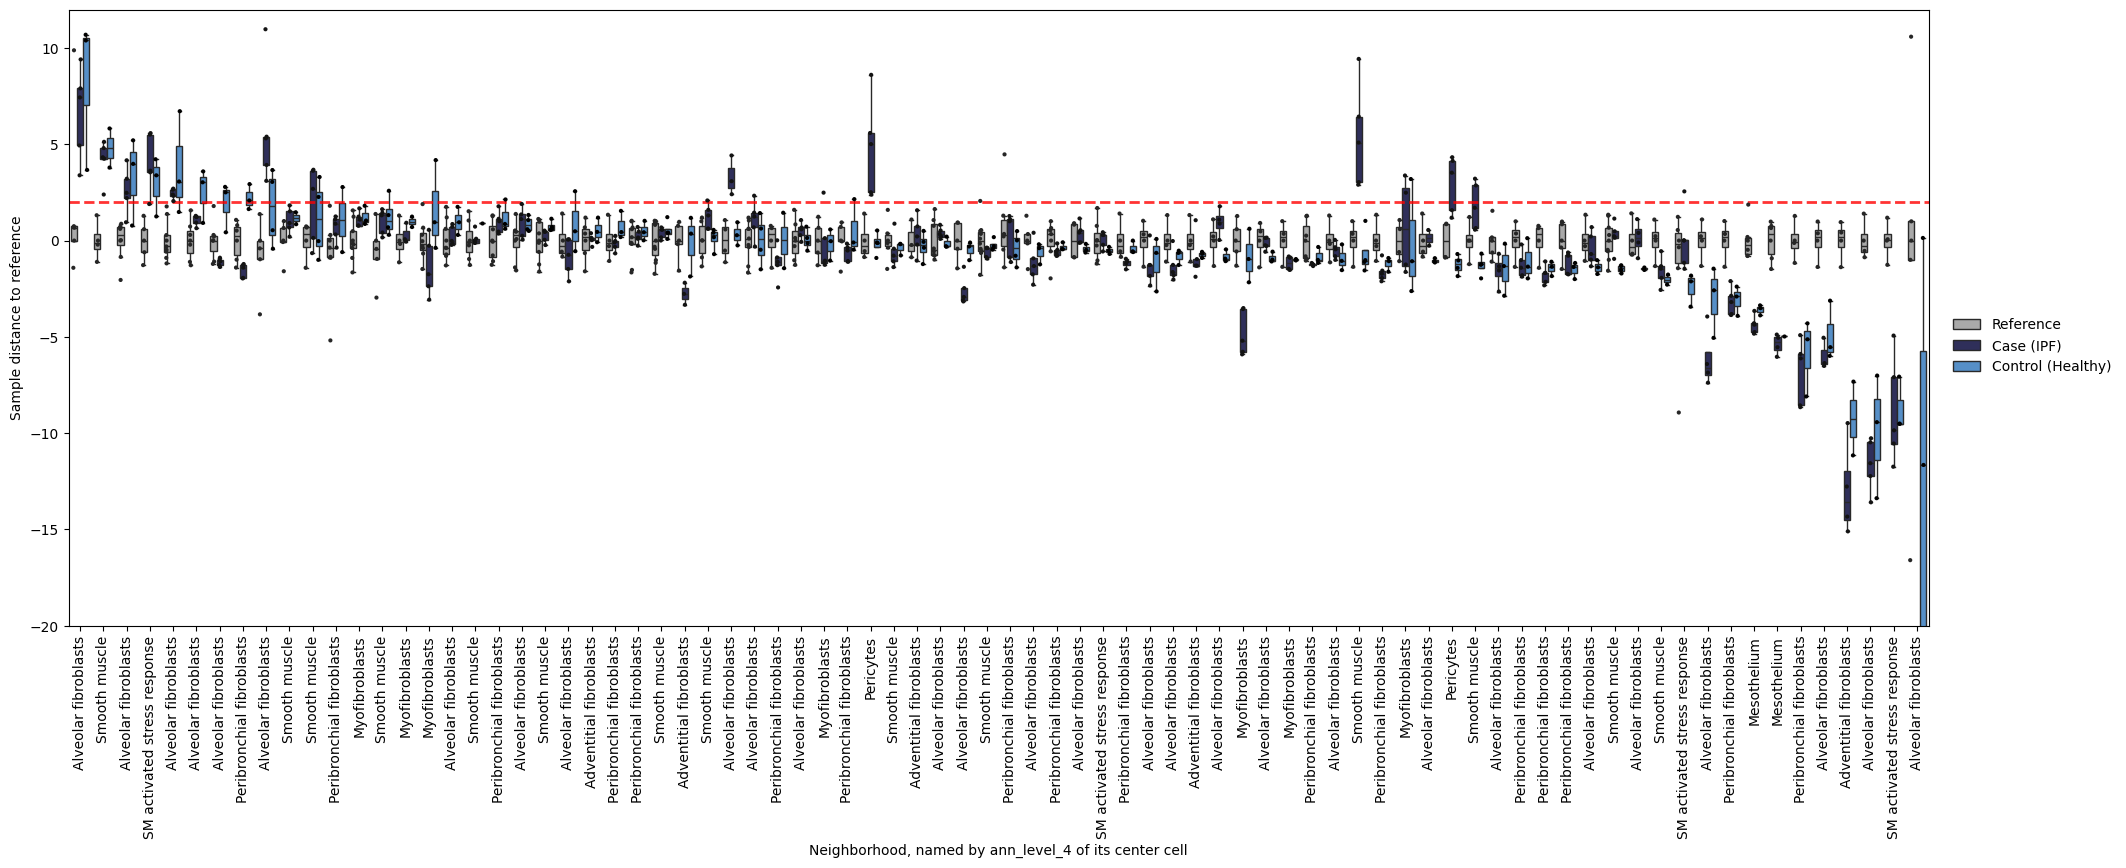

In [15]:
mapqc.pl.boxplot.sample_dists_to_ref_per_nhood(
    adata, sample_dists_to_ref_df=sample_dists, ylim=(-20, 12), label_xticks_by="ann_level_4"
)

Plotting the same boxplot without setting label_x_ticks_by will give us the neighborhood names (i.e. the barcode of their center cell) as x-tick labels, which we can use to zoom in on a specific neighborhood.

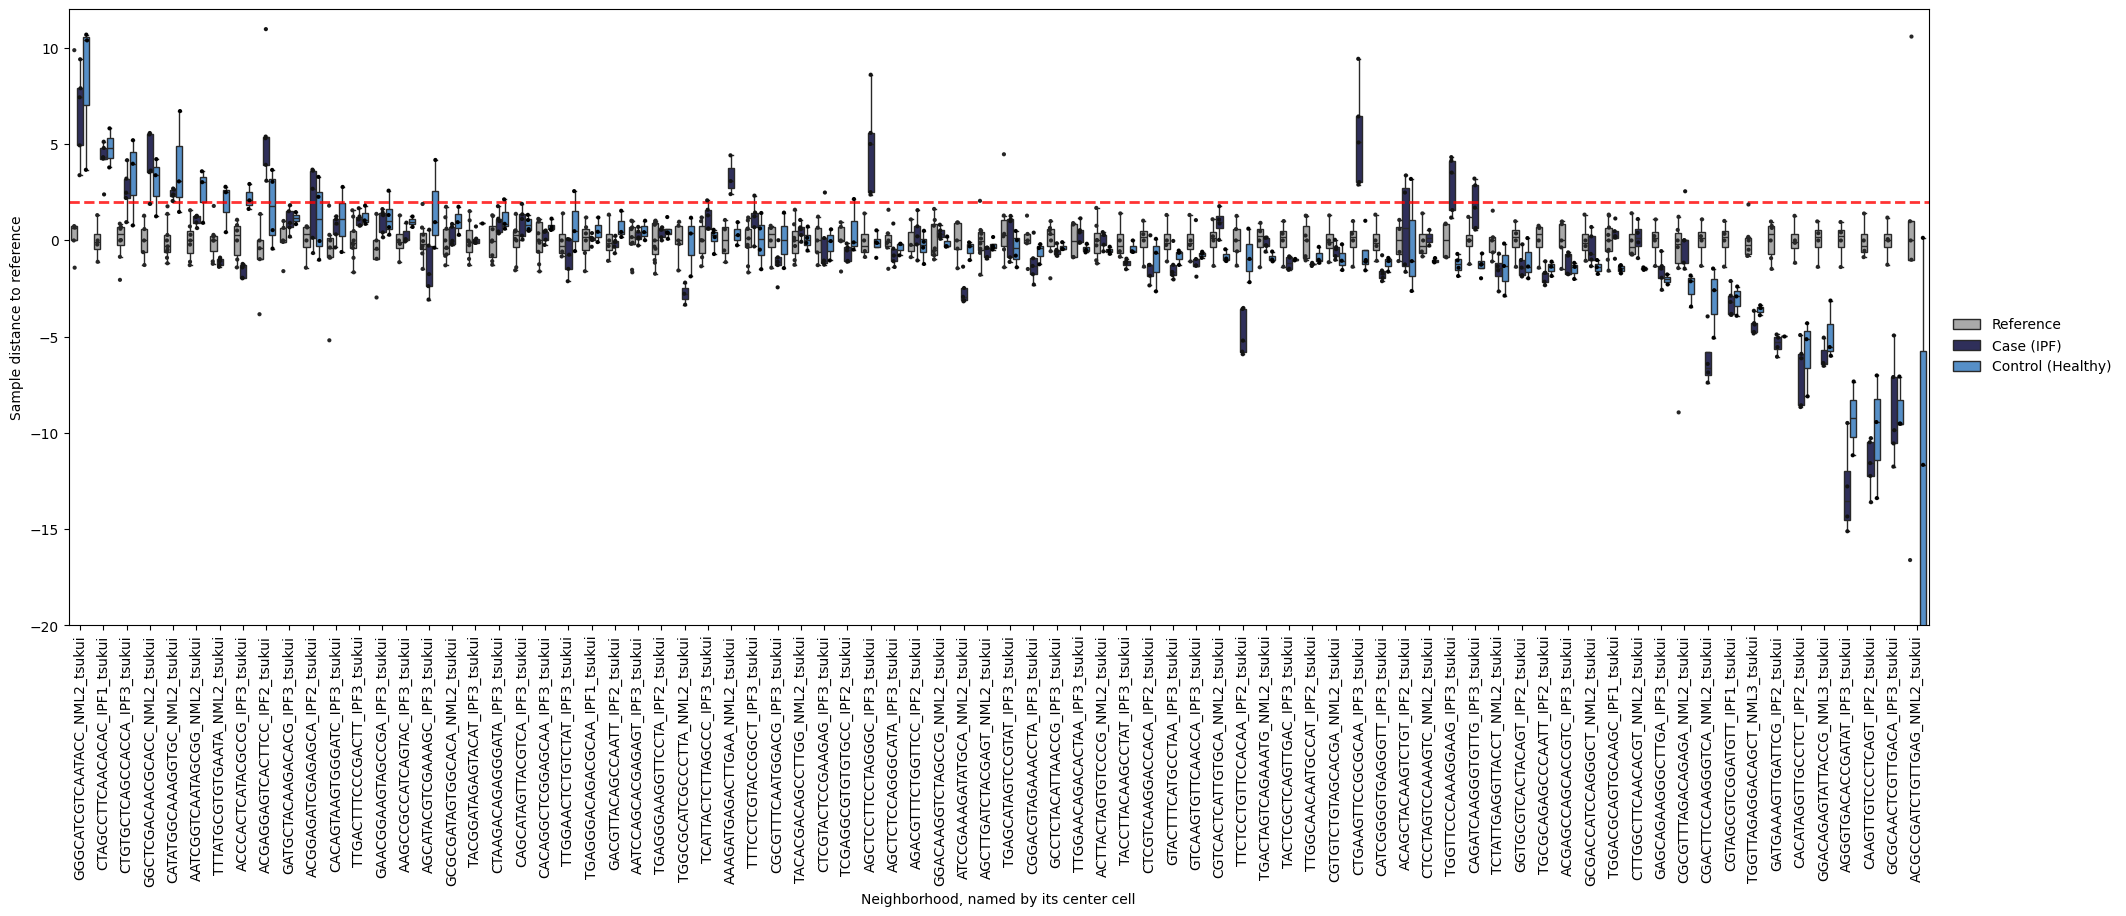

In [16]:
mapqc.pl.boxplot.sample_dists_to_ref_per_nhood(adata, sample_dists_to_ref_df=sample_dists, ylim=(-20, 12))

You can even take a look at a specific neighborhood, for example to get a feel for if your neighborhood size is too large. You can check if your neighborhoods do not cover a too wide range of cell states/types: in that case inter-sample distances might be dominated by distances between cell types rather than by inter-sample variation. Looking at the left-most neighborhood in the above plot, it seems to cover a good subset of cells (the continuum of alveolar and peribronchial fibroblasts), but it includes very few reference cells. Ideally, neighborhoods include more reference cells, which we can achieve by setting the filtering settings more stringently (e.g. increase `min_n_samples_r`in the `run_mapqc` command). However, in this mock dataset we are working with a set of cell types that was not well covered by the reference (stromal cells in the HLCA), and we therefore cannot afford more stringent filtering settings.

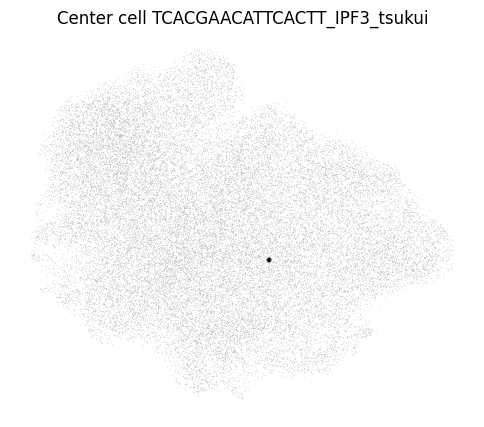

In [17]:
mapqc.pl.umap.neighborhood_center_cell(adata, center_cell="TCACGAACATTCACTT_IPF3_tsukui")

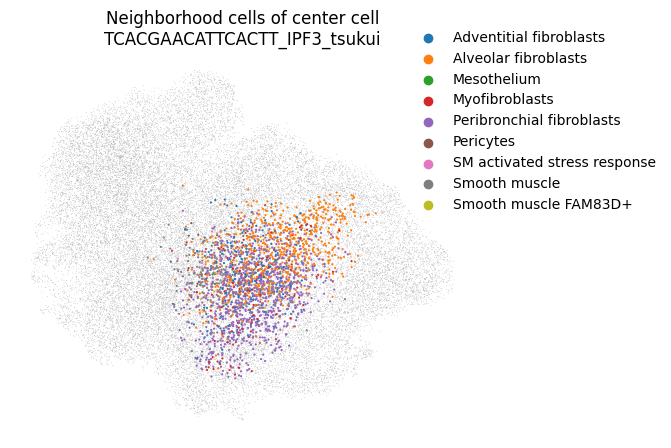

In [18]:
mapqc.pl.umap.neighborhood_cells(
    adata, center_cell="TCACGAACATTCACTT_IPF3_tsukui", nhood_info_df=nhood_info_df, color_by="ann_level_4"
)

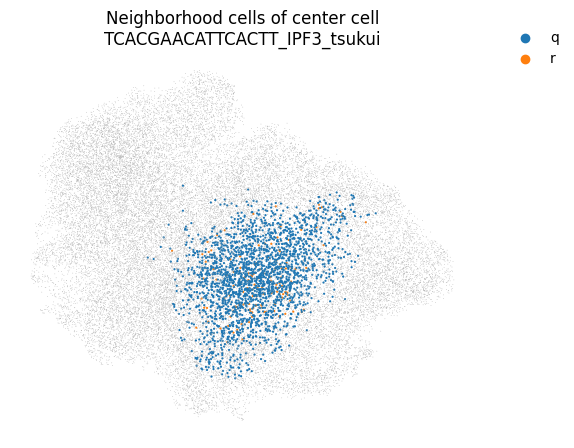

In [19]:
mapqc.pl.umap.neighborhood_cells(
    adata, center_cell="TCACGAACATTCACTT_IPF3_tsukui", nhood_info_df=nhood_info_df, color_by="r_or_q"
)

I hope this gave you a good overview of how to interpret and dig into your mapQC results. If you have any more questions, or any suggestions on how to improve the tutorials or mapQC itself, please let me know and submit an issue on the mapQC GitHub page. 